In [107]:
set = 'All'
balanced = True
passengers = False
trein = True
shallow = False

In [108]:
from fastai.tabular.all import *
import torch
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from IPython.display import clear_output, DisplayHandle
import os
from sklearn.utils import resample
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch
with open('../Odin/OdinData/odin-col-dict.json', "r") as json_file:
    choice_dict = json.load(json_file)

In [109]:
model_name = set
if passengers == True:
    model_name == '_passengers'
if balanced == True:
    model_name += '_balanced'
if trein == False:
    model_name += '_notrein'
if shallow == True:
    layers = [20, 10, 3]
else:
    layers = [200, 100, 20, 3]
    model_name += '_deep'

print(model_name)

All_balanced_deep


In [113]:
dep_var = 'khvm'
cols = ['vertpc', 'aankpc', 'khvm', 'weekdag',
       'bike_dur', 'bike_dist', 'car_dur',
       'car_dist', 'pt_dur', 'pt_dist', 'walk_dur', 'walk_dist', 'sin_time', 'cos_time'] #'choice_dur', 'choice_dist','oprijbewijsau'
rawdf = pd.read_pickle('../Odin/Odin2019' + set)[cols]
print(len(rawdf))

192618


In [114]:
#POSTCODE RESTRICTIONS TO SIMPLIFY EMBEDDING MATRIX
#
# aavc = rawdf.aankpc.value_counts()
# vevc = rawdf.vertpc.value_counts()
# i = aavc[aavc > 5].index
# i2 = vevc[vevc > 5].index
#
# df = rawdf[rawdf.aankpc.isin(i) & rawdf.vertpc.isin(i2)]

In [115]:
df = rawdf

if trein == False:
    df[dep_var] = df[dep_var].replace('Trein', 'Bus/tram/metro')
df[dep_var].unique()

df[dep_var].replace('Personenauto - passagier', 'Personenauto - bestuurder', inplace = True)
print(len(df))

df = df[df[dep_var] != 'Overig']

192618


In [116]:
def balance_multiclass(df, target_col):
    # Find out which class has the most entries
    max_size = df[target_col].value_counts().min()

    dfs = []

    for class_name, group in df.groupby(target_col):
        # For each group, randomly oversample with replacement to the size of the largest group
        df_group_resampled = resample(group, replace=True, n_samples=max_size, random_state=123)
        dfs.append(df_group_resampled)

    # Concatenate all groups and return
    return pd.concat(dfs, axis=0)
if balanced == True:
    df = balance_multiclass(df, 'khvm')

In [117]:
dep_var = 'khvm'
cat_names = list(df.select_dtypes(include=['object']).columns)
cont_names = [x for x in cols if x not in cat_names]
cat_names.remove(dep_var)

procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=procs, cat_names=cat_names,
                   cont_names=cont_names, y_names=dep_var,
                   splits = splits, y_block = CategoryBlock())
dls = to.dataloaders(bs=64, splits=splits)
# learn = tabular_learner(dls, layers=layers, metrics=accuracy)
learn = tabular_learner(dls, layers = layers, metrics=accuracy)

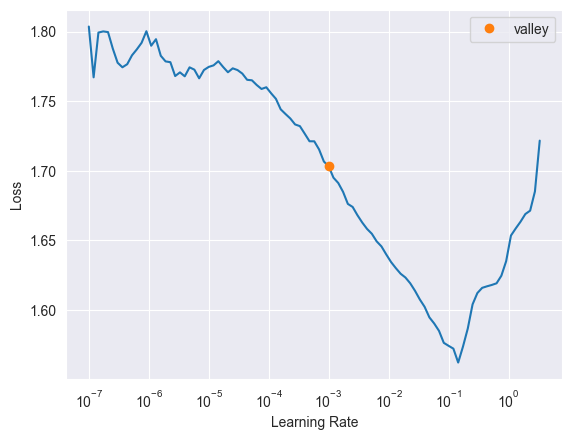

In [118]:
lr = learn.lr_find()

In [134]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.899761,1.014246,0.000000,00:16


In [135]:
os.makedirs(os.path.join('models', model_name), exist_ok = True)
learn.export(os.path.join('models', model_name, 'model.pkl'))
# learn = load_learner(os.path.join('ModelNames', model_name, 'model.pkl'))

In [136]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                           precision    recall  f1-score   support

           Bus/tram/metro       0.59      0.70      0.64      1540
                    Fiets       0.47      0.44      0.45      1532
Personenauto - bestuurder       0.49      0.42      0.45      1535
                  Te voet       0.67      0.63      0.65      1515
                    Trein       0.77      0.83      0.80      1523

                 accuracy                           0.60      7645
                macro avg       0.60      0.60      0.60      7645
             weighted avg       0.60      0.60      0.60      7645



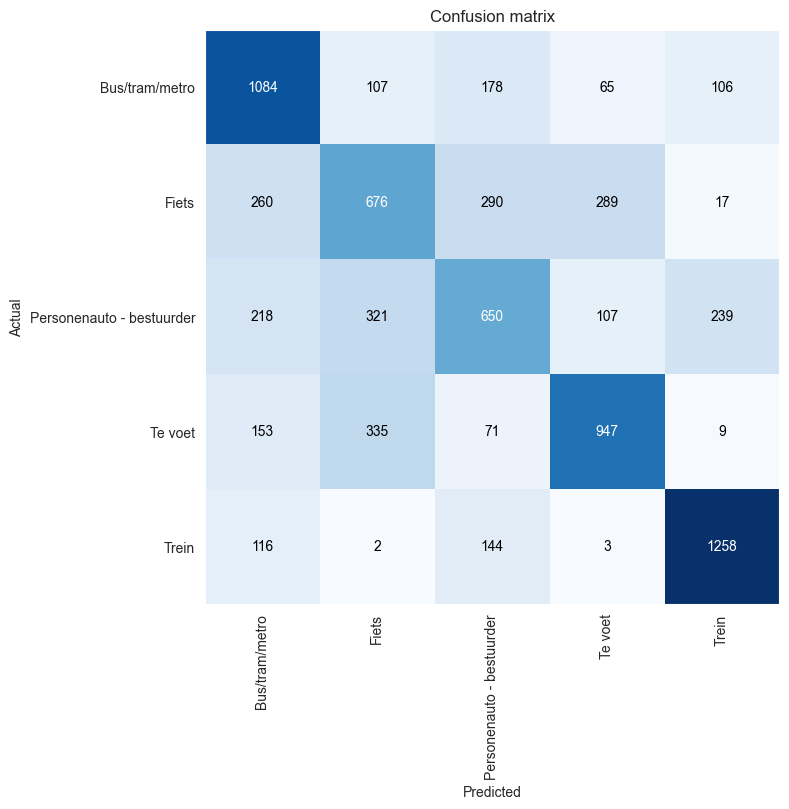

In [137]:
interp.plot_confusion_matrix(figsize=(8,8))

In [144]:
test_df = pd.read_pickle('../FelyxData/felyxotp')
test_df['choice_dist'] = test_df['distancemoved'] * 100000
test_df['choice_dur'] = test_df['timedelta'].dt.seconds
test_cols = [col for col in cols if col != dep_var]
test_df = test_df[test_cols]
# test_df.drop([''], axis=1, inplace=True)
dl = learn.dls.test_dl(test_df)

preds, _ = learn.get_preds(dl=dl)#, with_decoded=True)
preds = preds.argmax(dim=-1)
test_df['pred'] = [dl.vocab[pred] for pred in preds]
test_df.groupby('pred').count()

,vertpc,aankpc,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,walk_dist,sin_time,cos_time
pred,,,,,,,,,,,,,
Bus/tram/metro,896,896,896,896,896,896,896,896,896,896,896,896,896
Fiets,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358
Personenauto - bestuurder,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188
Te voet,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
Trein,2,2,2,2,2,2,2,2,2,2,2,2,2


In [145]:
test_df.groupby('pred').count()

,vertpc,aankpc,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,walk_dist,sin_time,cos_time
pred,,,,,,,,,,,,,
Bus/tram/metro,896,896,896,896,896,896,896,896,896,896,896,896,896
Fiets,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358,11358
Personenauto - bestuurder,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188
Te voet,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344,1344
Trein,2,2,2,2,2,2,2,2,2,2,2,2,2


In [140]:
learn.model.layers

Sequential(
  (0): LinBnDrop(
    (0): Linear(in_features=297, out_features=200, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): LinBnDrop(
    (0): Linear(in_features=200, out_features=100, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): LinBnDrop(
    (0): Linear(in_features=100, out_features=20, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (3): LinBnDrop(
    (0): Linear(in_features=20, out_features=3, bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (4): LinBnDrop(
    (0): Linear(in_features=3, out_features=5, bias=True)
  )
)

In [146]:
# Pass the test DataLoader through the trained model
hook = hook_output(learn.model.layers[-2])

hactslist = []

for i in [test_df, df]:
    dl = learn.dls.test_dl(i)

    all = []

    for batch in dl:
        # print(batch)
        b = (batch[0].to('mps:0'), batch[1].to('mps:0'))
        with torch.no_grad():
            learn.model.eval()
            _ = learn.model(*b)

        activations = hook.stored
        all.append(activations)

    hacts = np.concatenate([a.cpu() for a in all], axis=0)
    hactslist.append(hacts)

combinedhacts = np.concatenate(hactslist)
combinedhacts.shape

(53013, 3)

In [147]:
n_components = 3
combined = pd.concat([df, test_df])
combined['choice'] = pd.concat([combined[combined.khvm.notnull()].khvm, combined[combined.pred.notnull()].pred])
combined['train'] = (([1] * len(df)) + ([0] * len(test_df)))

combined[['Emb' + str(i) for i in range(n_components)]] = combinedhacts#np.concatenate([trainhacts, testhacts])

combined.to_pickle(os.path.join('models', model_name, 'predictions'))
combined.head()

,vertpc,aankpc,khvm,weekdag,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,walk_dist,sin_time,cos_time,pred,choice,train,Emb0,Emb1,Emb2
5583740128301,6541,6525,Bus/tram/metro,Woensdag,1551.0,6200.65,1393.0,5917.22,2174.0,7036.831973,4645.0,5829.03,0.034899,0.999391,NaN,Bus/tram/metro,1,1.886512,0.081102,-0.079078
5896524098804,3029,3117,Bus/tram/metro,Woensdag,980.0,4321.00,796.0,4364.00,1721.0,5745.000000,3285.0,4171.00,0.074108,0.997250,NaN,Bus/tram/metro,1,1.515233,0.799795,-0.878963
5912033863801,5667,5613,Bus/tram/metro,Zaterdag,1250.0,5509.00,1128.0,9823.00,1854.0,8068.000000,4214.0,5402.00,0.052336,0.998630,NaN,Bus/tram/metro,1,1.706749,-0.754752,0.748384
5896516296103,3453,3511,Bus/tram/metro,Zaterdag,1906.0,8285.00,1443.0,13088.00,2130.0,9686.000000,6484.0,8154.00,0.078459,0.996917,NaN,Bus/tram/metro,1,1.652233,0.075875,0.382406
5896833280402,3572,3437,Bus/tram/metro,Woensdag,2059.0,8937.00,1313.0,11444.00,2867.0,12603.000000,6979.0,8859.00,0.069756,0.997564,NaN,Bus/tram/metro,1,2.284997,-0.901749,0.963076


In [148]:
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, [pd.DataFrame(data = em, index = i) for i, em in zip(indices,embedding_matrices)]))

with open(os.path.join('models', model_name, 'embedding_dictionary'), 'wb') as f:
    pickle.dump(categ_dictionary, f)

print(categ_dictionary.keys())

dict_keys(['vertpc', 'aankpc', 'weekdag'])


In [ ]:
n_components = 3
pca = PCA(n_components=n_components)
redu = pca.fit_transform(np.concatenate([trainhacts, testhacts]))

combined[['PCA' + str(i) for i in range(n_components)]] = redu

In [56]:
# show = combined[combined.train == 1].sample(100)
combined = pd.concat([combined[combined.train == x].sample(5000) for x in [0,1]])

In [57]:
show = pd.concat([combined[combined.choice == x].sample(20) for x in combined.choice.unique()])

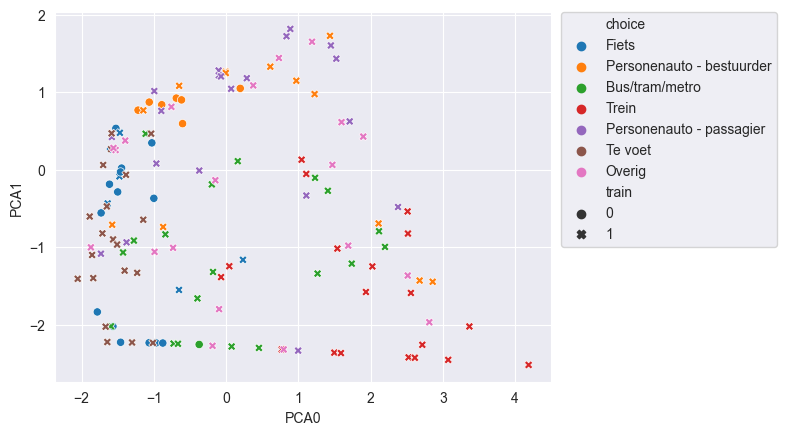

In [52]:
#2D option
sns.scatterplot(data = show, x = 'PCA0', y= 'PCA1', hue = 'choice', style = 'train')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

/var/folders/99/r_wg55g56p13sfs9r698z04w0000gn/T/ipykernel_9739/1045855428.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(show['choice'].unique()))


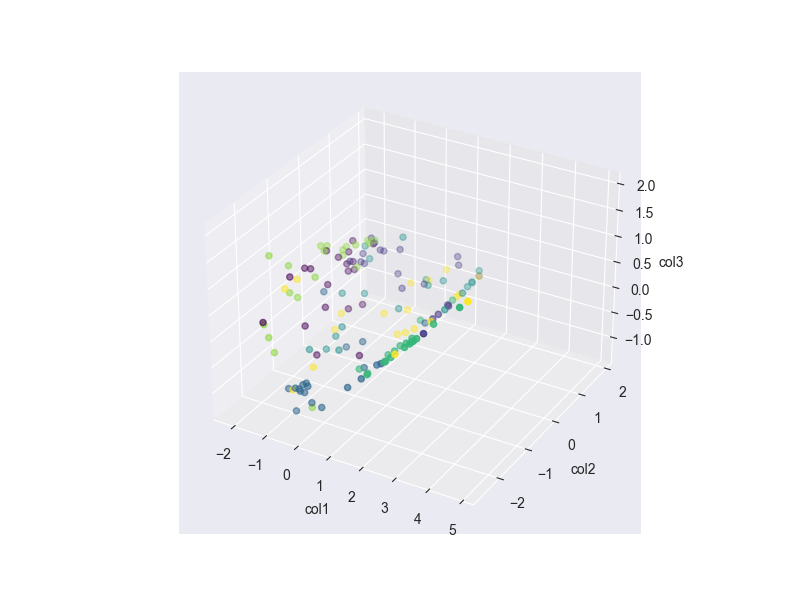

In [76]:
#3D Option
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
from matplotlib import cm
colormap = cm.get_cmap('viridis', len(show['choice'].unique()))
color_dict = {category: colormap(i) for i, category in enumerate(show['choice'].unique())}

ax.scatter(show['PCA0'], show['PCA1'], show['PCA2'], c=show.choice.map(color_dict), marker='o')

ax.set_xlabel('col1')
ax.set_ylabel('col2')
ax.set_zlabel('col3')
plt.show()

In [48]:
#Create a Dicitonary containing the embedding matrix for every categorical variable
embedding_matrices = [embed.weight.cpu().detach().numpy() for embed in learn.model.embeds]
category_names = [k for k, v in learn.dls.classes.items()]
indices = [learn.dls.classes[categ] for categ in learn.dls.classes.keys()]
categ_dictionary = dict(zip(category_names, embedding_matrices))
for i in categ_dictionary.keys():
    print(i, ': ', categ_dictionary[i].shape)

vertpc :  (1477, 95)
aankpc :  (1460, 95)
weekdag :  (8, 5)
hour :  (25, 10)


/Users/joshuathomas/PycharmProjects/EmbeddedMobility/venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


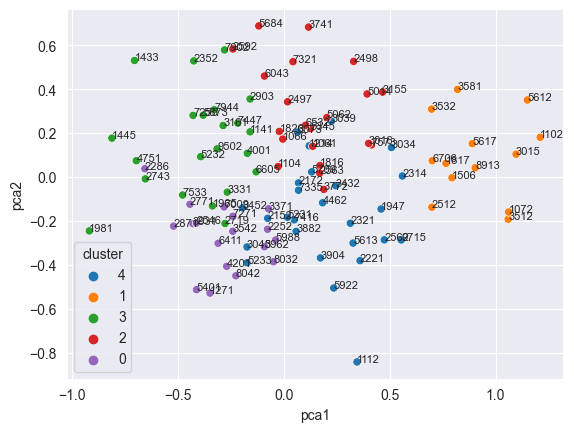

In [45]:
lablength = 10
categ = 'aankpc'
embedding_matrix = categ_dictionary[categ]
labels = learn.dls.classes[categ]

k = 5
kmeans = KMeans(n_clusters=k, random_state=0).fit(embedding_matrix)
# Give it the category name if the info is in the JSON
if categ in choice_dict.keys():
    labels = [choice_dict[categ].get(item, item)[:lablength] for item in [str(lab) for lab in labels]]
else:
    labels = [str(lab)[:lablength] for lab in labels]
pca = PCA(n_components=2)
mat_2d = pca.fit_transform(embedding_matrix)

PlotData = pd.DataFrame({'pca1': mat_2d[1:, 0], 'pca2': mat_2d[1:, 1],
                       categ: labels[1:], 'cluster':[str(x) for x in kmeans.labels_[1:]]})

if len(PlotData) > 100:
    PlotData = PlotData.sample(100)

sns.scatterplot(data = PlotData, x = 'pca1', y = 'pca2', hue = 'cluster')

for i in PlotData.index:
    plt.text(PlotData.pca1.loc[i], PlotData.pca2.loc[i], PlotData[categ][i], fontsize=8)